In [ ]:
# Segment 1: Setup Environment and Import Packages
########################################
!pip install s3fs tqdm transformers

import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  # For progress tracking in notebooks
from transformers import pipeline

# Initialize the sentiment analysis pipeline using a more accurate model.
# We use "nlptown/bert-base-multilingual-uncased-sentiment" which outputs star ratings (1 to 5).
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")


  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.6.0
    Uninstalling fsspec-2023.6.0:
      Successfully uninstalled fsspec-2023.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-ai 2.28.5 requires faiss-cpu!=1.8.0.post0,<2.0.0,>=1.8.0, which is not installed.
jupyter-scheduler 2.9.0 requires fsspec==2023.6.0, but you have fsspec 2025.2.0 which is incompatible.


2025-03-01 06:37:57.432765: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-01 06:37:57.455528: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from summarizer import Summarizer  # BERT extractive summarizer
from tqdm.notebook import tqdm     # Progress bar for notebooks


In [ ]:
# Segment 2: Read the CSV File from S3 (SageMaker)
########################################
# Specify the S3 file path for your CSV file.
file_path = "s3://amazon-sagemaker-058264306111-us-east-1-e23504aef6c5/dzd_5l5kah6gnsnq3r/3ufbjqy9l96f1j/dev/tucson_pizza_reviews_Cleaned.csv"

try:
    df = pd.read_csv(file_path)
    print("Data loaded successfully:")
    print(df.head())
except Exception as e:
    print("Error reading the CSV file from S3:")
    print(e)


Data loaded successfully:
                review_id                 user_id             business_id  \
0  2-Y4QSgJXEYFJTJIo71IPQ  IPcgVWB-KXlb5bqt8fqE0Q  KDC4yE8av8-A5TxgmjjUiw   
1  bFz6i8UdmIwgyTU0et2EjQ  Nay3mMq0PpjX1-WXx_IdpQ  7-cD0S7vJlUOuTpF2vQLOQ   
2  CJ_hijMxNGyPbmievHa2Aw  rVONIZ9xbSCcN7W0qYwPQA  Ei5HBqe012ImhqEr2ZH2gg   
3  1cw4pq3BD_G529mu1OcOeQ  yPEZsd_qc0TMkijvGwnV7Q  KDC4yE8av8-A5TxgmjjUiw   
4  MVdhVDYj20hH4G3-wFV8dQ  dVBROupIiiWzfcEFJlrthQ  rd5OW7v_vqlh6vVoQdLEhQ   

   stars  useful  funny  cool  \
0      3       1      1     1   
1      1       0      0     0   
2      5       1      0     2   
3      1       0      0     0   
4      4       0      0     0   

                                                text              date  \
0  Me and the family came in on a Thursday for a ...    3/13/2020 1:43   
1  They have the worst customer service skills im...    1/30/2020 4:44   
2  Loved it! Amazing pizza and bread! I even boug...    1/30/2020 2:55   
3  The staff was

Overall aspect counts: [('service', 1602), ('cheese', 931), ('sauce', 894), ('crust', 730), ('taste', 590), ('price', 576), ('environment', 52), ('ambience', 33), ('hygiene', 2), ('delivery speed', 0)]


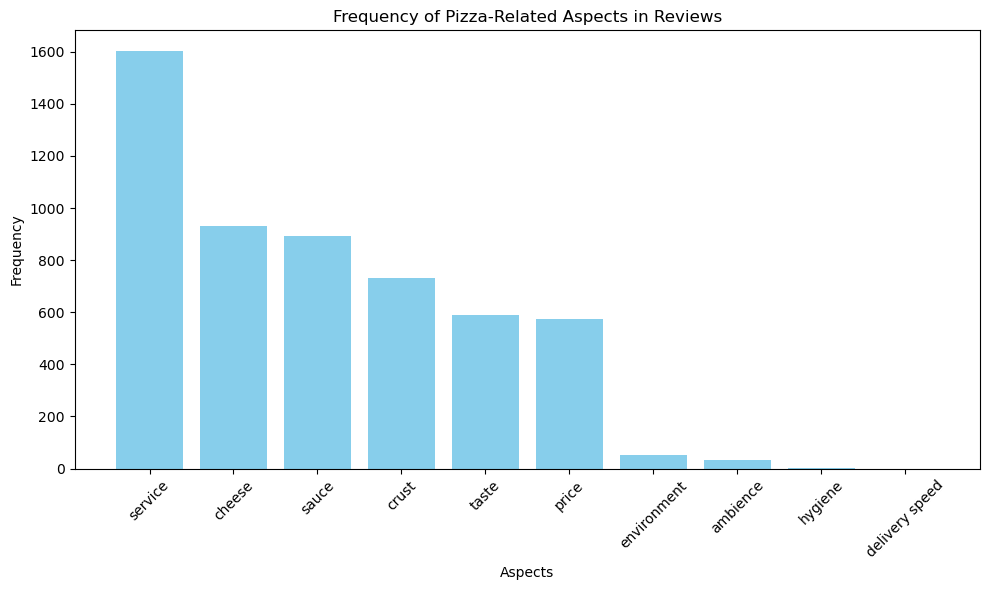

Top 10 aspects (for sentiment evaluation): ['service', 'cheese', 'sauce', 'crust', 'taste', 'price', 'environment', 'ambience', 'hygiene', 'delivery speed']

First 30 texts with extracted aspects:
                                                 text  \
0   Me and the family came in on a Thursday for a ...   
1   They have the worst customer service skills im...   
2   Loved it! Amazing pizza and bread! I even boug...   
3   The staff was extremely rude here. The wait st...   
4   Posto Sano was great. Found out about it going...   
5   I have been frequenting Rosati's for at least ...   
6   Been here before and brushed this place off. B...   
7   Am I back in Chicago?!?   A really solid meatb...   
8   It's still a great concept which I like very m...   
9   Great white pizza,  wings, and cheese sticks. ...   
10  Best New York or Neapolitan style pizza in the...   
11  I ordered delivery, the pizzas arrived hot and...   
12  This is a new concept restaurant by Daniel Sco...   
13  A

In [ ]:
# Segment 3: Analyze Frequently Mentioned Aspects, Visualize, and Extract Keywords
########################################
# Define an extended list of pizza-related aspects in English.
aspects = [
    "taste",         # Overall flavor profile
    "crust",         # Crust quality and texture
    "sauce",         # Sauce quality
    "cheese",        # Cheese flavor and quality
    "hygiene",       # Cleanliness / food safety
    "delivery speed",# Speed of delivery
    "service",       # Customer service quality
    "price",         # Value for money
    "environment",   # Overall restaurant environment
    "ambience"       # Atmosphere/feel of the place
]

# Combine all review texts from the "text" column into one string.
all_text = " ".join(df["text"].astype(str))

# Count the frequency of each aspect (case-insensitive) over the entire dataset.
aspect_counts = {}
for aspect in aspects:
    aspect_counts[aspect] = all_text.lower().count(aspect.lower())

# Sort aspects by frequency (highest first).
sorted_aspects = sorted(aspect_counts.items(), key=lambda x: x[1], reverse=True)
print("Overall aspect counts:", sorted_aspects)

# Visualize the aspect frequencies using a bar chart.
plt.figure(figsize=(10, 6))
plt.bar([x[0] for x in sorted_aspects], [x[1] for x in sorted_aspects], color='skyblue')
plt.xlabel("Aspects")
plt.ylabel("Frequency")
plt.title("Frequency of Pizza-Related Aspects in Reviews")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# For further processing, select the top 10 aspects.
top_10_aspects = [aspect for aspect, count in sorted_aspects[:10]]
print("Top 10 aspects (for sentiment evaluation):", top_10_aspects)

# Extract aspects mentioned in each review.
df["aspects_found"] = df["text"].apply(lambda x: [aspect for aspect in aspects if aspect.lower() in x.lower()])

# Print the first 30 rows of "text" along with the extracted "aspects_found" column.
print("\nFirst 30 texts with extracted aspects:")
print(df[["text", "aspects_found"]].head(30))


In [ ]:
# Segment 4: Compute Sentiment Ratings & Overall Scores per Business
########################################
# Helper function: Convert the star rating output to a score on a 0–10 scale.
# "nlptown/bert-base-multilingual-uncased-sentiment" returns labels like "1 star", "2 stars", ..., "5 stars".
# We map 1 star -> 0 and 5 stars -> 10 linearly.
def get_rating_0_10(sent_output):
    # Extract the star number from the label.
    label = sent_output[0]["label"]
    try:
        star = int(label.split()[0])
    except Exception:
        star = 3  # default neutral value if parsing fails
    # Map 1 star -> 0, 5 stars -> 10.
    rating = (star - 1) / 4 * 10
    return rating

if "df" in globals() and "business_id" in df.columns:
    business_scores = {}  # Dictionary to store each business's aspect ratings and overall score.

    # Process each business_id group with a progress bar.
    for business_id, group in tqdm(list(df.groupby("business_id")), desc="Processing Businesses"):
        aspect_ratings = {}       # To store average rating for each aspect for this business.
        aspect_review_counts = {} # To store number of reviews mentioning each aspect.

        # For each of the top 10 aspects:
        for aspect in top_10_aspects:
            # Filter reviews where the aspect is mentioned (case-insensitive).
            aspect_reviews = group[group["text"].str.contains(aspect, case=False, na=False)]["text"]
            ratings = []
            for review in aspect_reviews:
                try:
                    sent_output = sentiment_pipeline(review)
                    rating = get_rating_0_10(sent_output)
                    ratings.append(rating)
                except Exception as e:
                    continue  # Skip review if an error occurs.
            if ratings:
                avg_rating = sum(ratings) / len(ratings)
                aspect_ratings[aspect] = avg_rating
                aspect_review_counts[aspect] = len(ratings)
            else:
                aspect_ratings[aspect] = "N/A"
                aspect_review_counts[aspect] = 0

        business_scores[business_id] = {
            "aspect_ratings": aspect_ratings,
            "review_counts": aspect_review_counts
        }

    # Print the average ratings for each business.
    print("\n=== Business Average Aspect Ratings ===")
    for bid, details in business_scores.items():
        print(f"Business ID: {bid}")
        for aspect in top_10_aspects:
            print(f"  {aspect}: {details['aspect_ratings'][aspect]} (Reviews: {details['review_counts'][aspect]})")
        print()

    # For the target categories: service, cheese, sauce, crust, and taste,
    # list the top 5 businesses by average rating (ignoring "N/A").
    target_categories = ["service", "cheese", "sauce", "crust", "taste"]

    print("\n=== Top 5 Businesses per Target Category ===")
    for category in target_categories:
        valid_ratings = [(bid, details["aspect_ratings"][category])
                         for bid, details in business_scores.items()
                         if details["aspect_ratings"].get(category) != "N/A"]
        sorted_businesses = sorted(valid_ratings, key=lambda x: x[1], reverse=True)
        print(f"\nTop 5 for {category.capitalize()}:")
        for bid, rating in sorted_businesses[:5]:
            print(f"  Business ID: {bid} -> Average Rating: {rating:.2f}")
else:
    print("Either 'df' is not defined or the 'business_id' column is missing.")

Processing Businesses:   0%|          | 0/183 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (688 > 512). Running this sequence through the model will result in indexing errors



=== Business Average Aspect Ratings ===
Business ID: 0BnjHJ8H5F15KjeMgDCBAA
  service: 10.0 (Reviews: 3)
  cheese: 7.5 (Reviews: 2)
  sauce: N/A (Reviews: 0)
  crust: N/A (Reviews: 0)
  taste: N/A (Reviews: 0)
  price: N/A (Reviews: 0)
  environment: N/A (Reviews: 0)
  ambience: N/A (Reviews: 0)
  hygiene: N/A (Reviews: 0)
  delivery speed: N/A (Reviews: 0)

Business ID: 0QeEnTzmUTQHie1MPZVHLg
  service: 10.0 (Reviews: 1)
  cheese: N/A (Reviews: 0)
  sauce: 2.5 (Reviews: 1)
  crust: 3.75 (Reviews: 2)
  taste: 6.25 (Reviews: 2)
  price: N/A (Reviews: 0)
  environment: N/A (Reviews: 0)
  ambience: N/A (Reviews: 0)
  hygiene: N/A (Reviews: 0)
  delivery speed: N/A (Reviews: 0)

Business ID: 0djt76NXDYMtjJvL2rHIQg
  service: 0.0 (Reviews: 1)
  cheese: N/A (Reviews: 0)
  sauce: 10.0 (Reviews: 1)
  crust: N/A (Reviews: 0)
  taste: N/A (Reviews: 0)
  price: 2.5 (Reviews: 1)
  environment: N/A (Reviews: 0)
  ambience: N/A (Reviews: 0)
  hygiene: N/A (Reviews: 0)
  delivery speed: N/A (Reviews

In [ ]:
import pandas as pd

# Assuming 'business_scores' is still available in your environment
if 'business_scores' in globals():
    # Convert business_scores dictionary to a DataFrame
    business_scores_df = pd.DataFrame.from_dict(business_scores, orient='index')

    # Flatten nested aspect_ratings and review_counts
    business_scores_df = pd.concat([business_scores_df.drop(['aspect_ratings', 'review_counts'], axis=1),
                                     business_scores_df['aspect_ratings'].apply(pd.Series),
                                     business_scores_df['review_counts'].apply(pd.Series)], axis=1)

    # Save the DataFrame to a CSV file
    business_scores_df.to_csv('business_scores.csv', index_label='business_id')
    print("Business scores saved to business_scores.csv")
else:
    print("The 'business_scores' variable is not found in the environment.")

Business scores saved to business_scores.csv


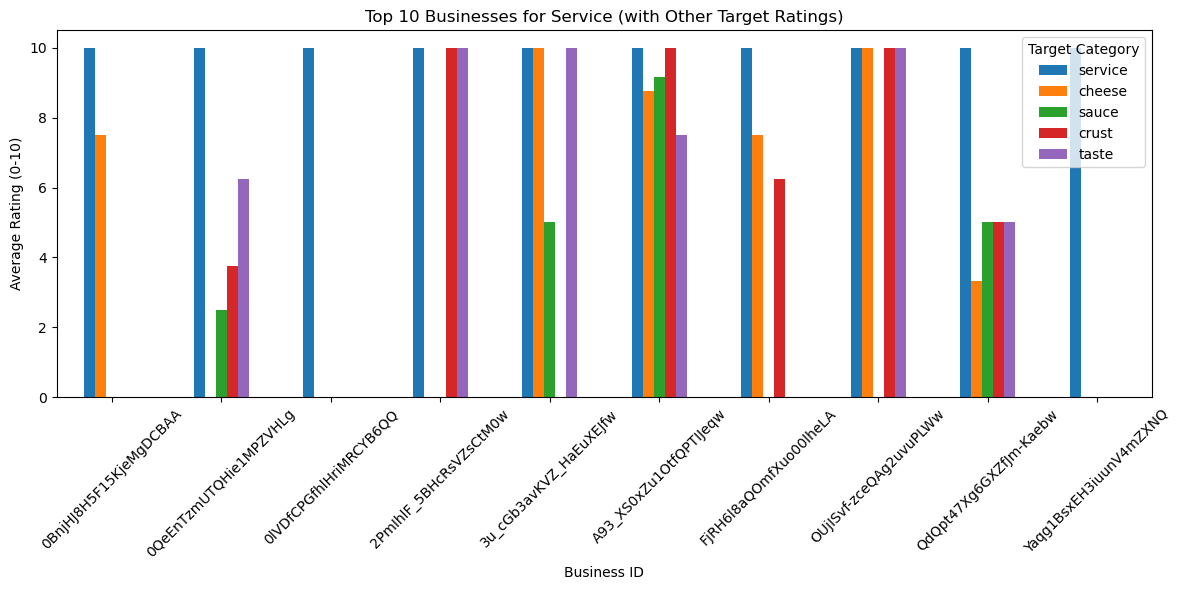

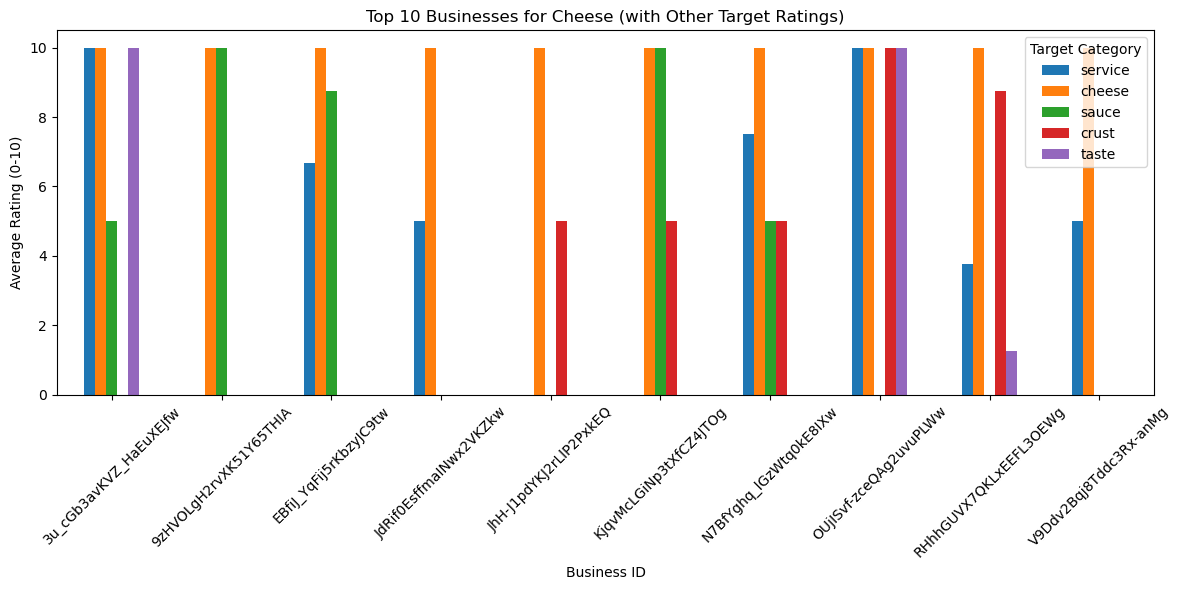

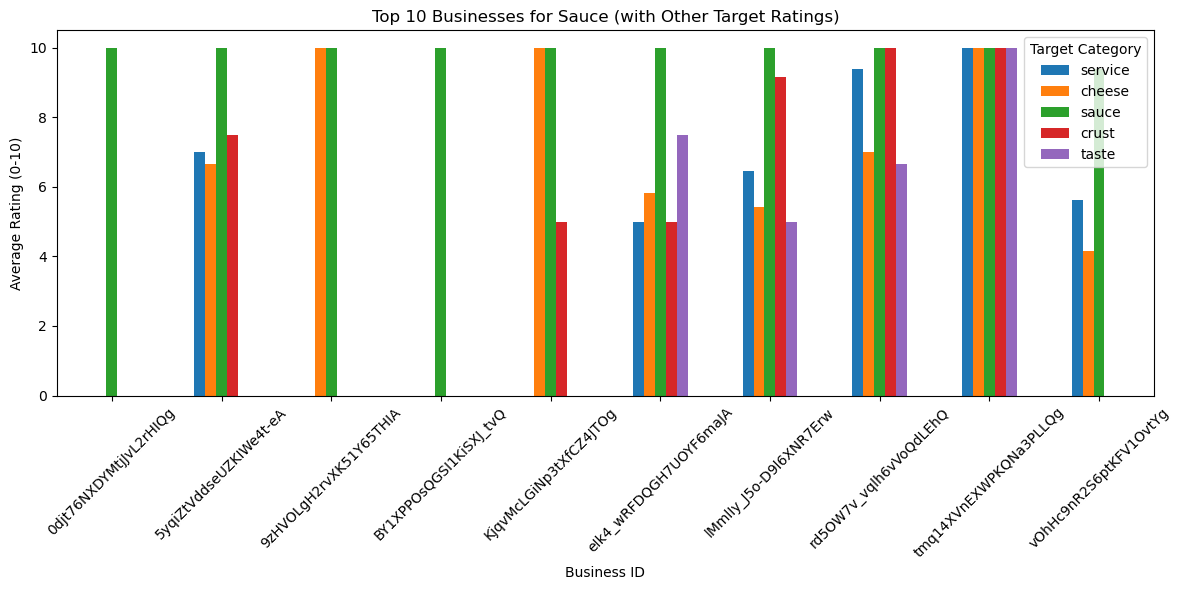

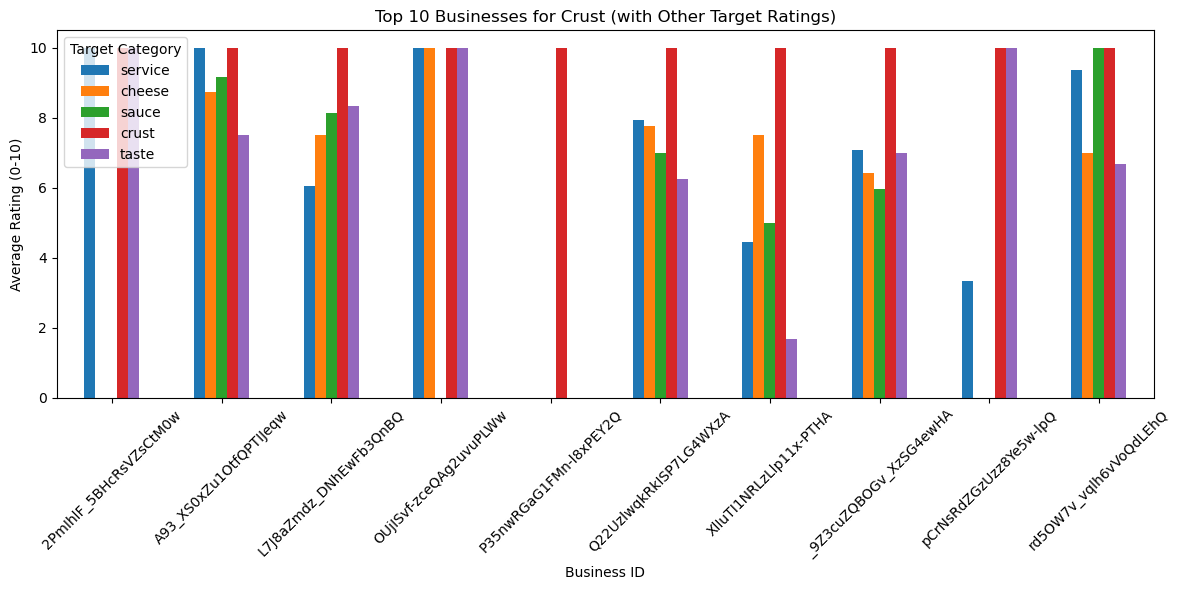

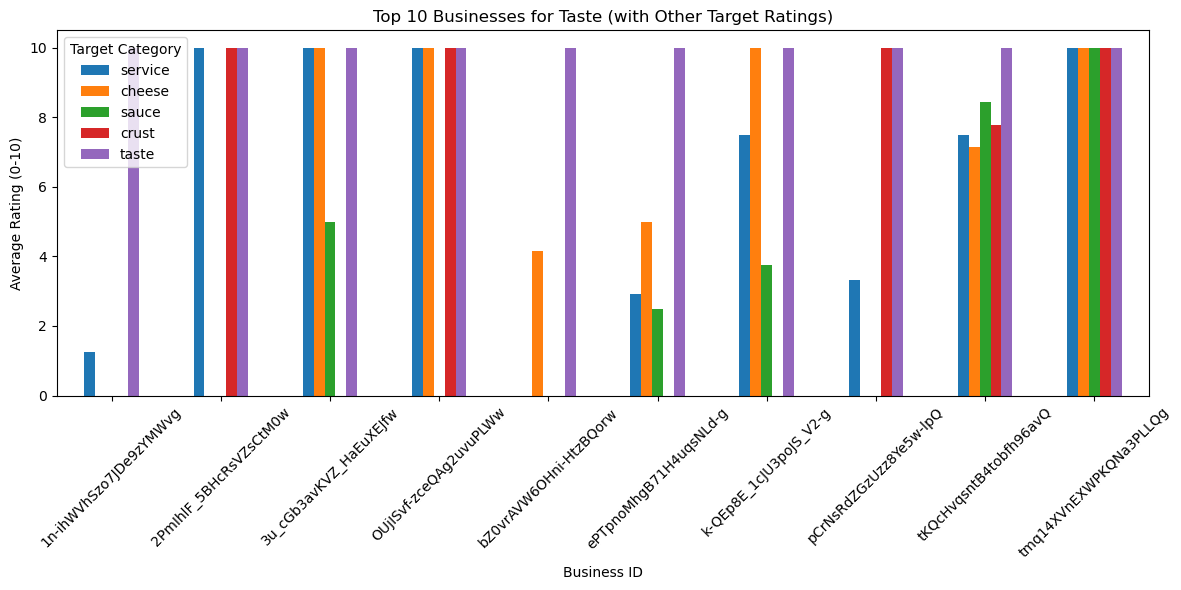

In [ ]:
########################################
# Segment 5: Visualize Top 10 Businesses per Target Category
########################################
import numpy as np  # Ensure numpy is imported

# Define the five target categories
target_categories = ["service", "cheese", "sauce", "crust", "taste"]

# For each target category, we sort businesses by the average rating for that category
# and then create a grouped bar chart displaying ratings for all five target categories.
for category in target_categories:
    # Build a list of (business_id, rating) tuples for businesses with a valid rating in this category.
    valid_list = [(bid, details["aspect_ratings"][category])
                  for bid, details in business_scores.items()
                  if details["aspect_ratings"].get(category) != "N/A"]
    # Sort the list in descending order by rating.
    sorted_list = sorted(valid_list, key=lambda x: x[1], reverse=True)
    top_10 = sorted_list[:10]

    # Build a DataFrame with the ratings for all five target categories for these top 10 businesses.
    data = []
    b_ids = []
    for bid, _ in top_10:
        b_ids.append(bid)
        row = {}
        for cat in target_categories:
            rating = business_scores[bid]["aspect_ratings"].get(cat, "N/A")
            # Convert "N/A" to NaN so that missing values are not plotted.
            row[cat] = rating if rating != "N/A" else np.nan
        data.append(row)
    df_top = pd.DataFrame(data, index=b_ids)

    # Plot a grouped bar chart.
    ax = df_top.plot(kind="bar", figsize=(12, 6))
    ax.set_title(f"Top 10 Businesses for {category.capitalize()} (with Other Target Ratings)")
    ax.set_xlabel("Business ID")
    ax.set_ylabel("Average Rating (0-10)")
    plt.xticks(rotation=45)
    plt.legend(title="Target Category")
    plt.tight_layout()
    plt.show()


In [ ]:
!pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Classification DataFrame (Rows: Target Categories, Columns: Business IDs):
        4QMIJJWQOh7zpEwOXhFJqw mTnp8g8vFnuJso_NK7sR4A B10mqANgHvL8gBteo1UhAA  \
service                   Good                 Normal                 Normal   
cheese                    Good                    Bad                   Good   
sauce                     Good                    Bad                 Normal   
crust                     Good                 Normal                    Bad   
taste                   Normal                    Bad                 Normal   

        8YM2oTP6LZYQlwB6Hk9lLA eIk4_wRFDQGH7UOYF6maJA 11vPrvRixIre4nnwlMo32A  \
service                 Normal                 Normal                 Normal   
cheese                    Good                 Normal                   Good   
sauce                   Normal                   Good                   Good   
crust                     Good                 Normal                   Good   
taste                      Bad              

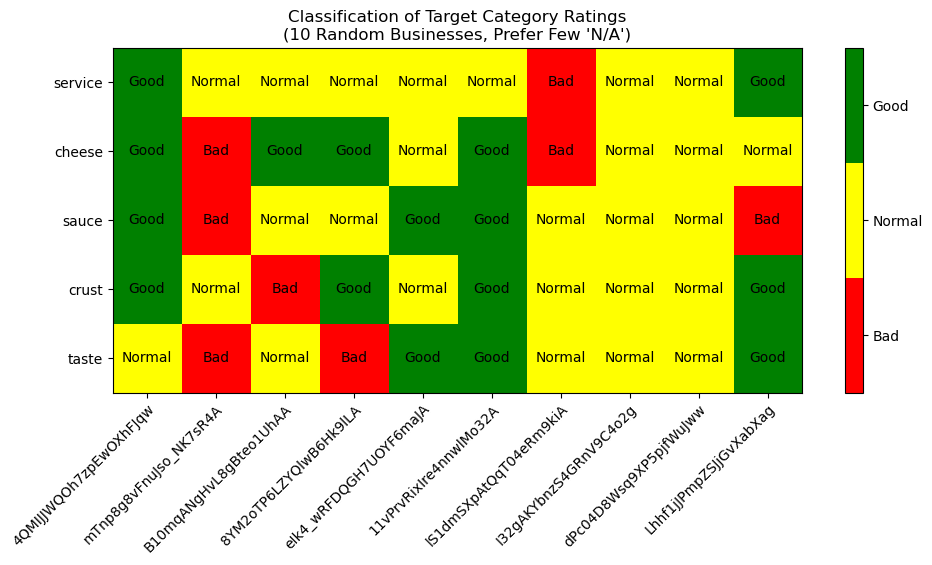

In [ ]:
########################################
# Segment 6: Visualize Classification for Target Categories (service, cheese, sauce, crust, taste)
#           Randomly select 10 businesses, preferring those with fewer "N/A" values.
########################################
import random
import numpy as np
import matplotlib.pyplot as plt

# Define the target categories.
target_categories = ["service", "cheese", "sauce", "crust", "taste"]

# Helper function to classify a rating into "Bad", "Normal", or "Good".
def classify_rating(rating):
    if isinstance(rating, (int, float)):
        if rating < 4.1:
            return "Bad"
        elif rating < 7:
            return "Normal"
        else:
            return "Good"
    else:
        return rating  # If not numeric, return as is (e.g., "N/A").

# For each business in business_scores, count how many of the target categories are "N/A".
na_counts = {}
for bid, details in business_scores.items():
    count_na = sum(1 for cat in target_categories if details["aspect_ratings"].get(cat) == "N/A")
    na_counts[bid] = count_na

# First, select businesses with the minimum number of "N/A" among target categories.
min_na = min(na_counts.values())
preferred_businesses = [bid for bid, count in na_counts.items() if count == min_na]

# If we have more than 10 preferred businesses, randomly choose 10 from them.
# Otherwise, we select them and fill the rest with businesses having the next lowest N/A count.
selected_businesses = []
if len(preferred_businesses) >= 10:
    selected_businesses = random.sample(preferred_businesses, 10)
else:
    # Start with preferred ones.
    selected_businesses = preferred_businesses.copy()
    # Get remaining businesses sorted by increasing N/A count (excluding those already selected).
    remaining = [bid for bid in business_scores.keys() if bid not in selected_businesses]
    remaining = sorted(remaining, key=lambda bid: na_counts[bid])
    # Randomly sample from the sorted remaining until we have 10 businesses.
    needed = 10 - len(selected_businesses)
    if len(remaining) >= needed:
        selected_businesses += random.sample(remaining, needed)
    else:
        selected_businesses += remaining

# Build a classification dictionary for each selected business for the target categories.
classification_data = {}
for bid in selected_businesses:
    classifications = {}
    for cat in target_categories:
        rating = business_scores[bid]["aspect_ratings"].get(cat, "N/A")
        classifications[cat] = classify_rating(rating)
    classification_data[bid] = classifications

# Convert the dictionary to a DataFrame: rows are target categories, columns are business IDs.
df_class = pd.DataFrame(classification_data)
df_class = df_class.reindex(index=target_categories)
print("Classification DataFrame (Rows: Target Categories, Columns: Business IDs):")
print(df_class)

# Map the categorical classifications to numeric values for visualization:
# "Bad" -> 0, "Normal" -> 1, "Good" -> 2. Other values become NaN.
mapping = {"Bad": 0, "Normal": 1, "Good": 2}
df_numeric = df_class.replace(mapping)
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')  # Convert non-numeric (like "N/A") to NaN

# Plot a heatmap using matplotlib's imshow.
fig, ax = plt.subplots(figsize=(10, 5))
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["red", "yellow", "green"])
im = ax.imshow(df_numeric.values, cmap=cmap, vmin=-0.5, vmax=2.5)

# Set ticks and labels.
ax.set_xticks(np.arange(df_numeric.shape[1]))
ax.set_yticks(np.arange(df_numeric.shape[0]))
ax.set_xticklabels(df_numeric.columns)
ax.set_yticklabels(df_numeric.index)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate each cell with its classification.
for i in range(df_numeric.shape[0]):
    for j in range(df_numeric.shape[1]):
        text = df_class.iloc[i, j]
        ax.text(j, i, text, ha="center", va="center", color="black")

ax.set_title("Classification of Target Category Ratings\n(10 Random Businesses, Prefer Few 'N/A')")
cbar = fig.colorbar(im, ticks=[0, 1, 2], ax=ax)
cbar.ax.set_yticklabels(["Bad", "Normal", "Good"])
plt.tight_layout()
plt.show()
